<a href="https://colab.research.google.com/github/amal274/Autoencoder/blob/main/autoencoder_signature_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Restauration de signatures bruitées avec un Autoencodeur

Ce notebook crée plusieurs copies bruitées d'une signature fournie, redimensionne les images à 128×128, entraîne un autoencodeur convolutionnel (Keras/TensorFlow) pour restaurer la signature originale, et affiche des comparaisons (original / bruitée / restaurée).


1. Installation & imports :

In [ ]:
# Installation (décommente si nécessaire sur Colab)
# !pip install -q tensorflow matplotlib opencv-python

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
drive.mount('/content/drive')

# Reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print('Imports OK, TensorFlow version:', tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imports OK, TensorFlow version: 2.19.0


2. Paramètres de base :

In [ ]:
# Dossier contenant toutes les signatures (modifie si besoin)
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/Signatures"

# Hyperparamètres
IMG_SIZE = 128        # redimensionnement (128x128)
COPIES_PAR_IMAGE = 20 # nombre de versions bruitées par image
NOISE_STD = 0.25      # intensité du bruit gaussien
BATCH_SIZE = 8
EPOCHS = 80
MODEL_PATH = "autoencoder_signatures_dataset.h5"

3. Fonctions utilitaires :

In [ ]:
def load_and_preprocess_image(path, img_size=IMG_SIZE):
    """Charge une image en niveaux de gris, redimensionne et normalise [0,1]."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image introuvable : {path}")
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    return img

def add_gaussian_noise(img, std=NOISE_STD):
    """Ajoute du bruit gaussien à une image normalisée [0,1]."""
    noise = np.random.normal(0.0, std, img.shape)
    noisy = np.clip(img + noise, 0.0, 1.0)
    return noisy


4. Chargement du dataset et génération du bruit :

In [ ]:
images = []
for fname in os.listdir(DATASET_DIR):
    if fname.lower().endswith(".jpg"):
        path = os.path.join(DATASET_DIR, fname)
        img = load_and_preprocess_image(path)
        images.append(img)

print(f"{len(images)} images chargées depuis {DATASET_DIR}")

X_clean, X_noisy = [], []

for img in images:
    for _ in range(COPIES_PAR_IMAGE):
        noisy = add_gaussian_noise(img, std=NOISE_STD * np.random.uniform(0.8, 1.2))
        X_noisy.append(noisy)
        X_clean.append(img)

X_clean = np.array(X_clean)[..., np.newaxis].astype(np.float32)
X_noisy = np.array(X_noisy)[..., np.newaxis].astype(np.float32)

print("Forme finale du dataset :", X_clean.shape)

50 images chargées depuis /content/drive/MyDrive/Colab Notebooks/Signatures
Forme finale du dataset : (1000, 128, 128, 1)


In [ ]:
import os

# Create the directory if it doesn't exist
if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR)
    print(f"Directory '{DATASET_DIR}' created. Please upload your signature images (JPG) into this directory.")
else:
    print(f"Directory '{DATASET_DIR}' already exists.")

Directory '/content/drive/MyDrive/Colab Notebooks/Signatures' already exists.


5. Division train / validation / test :

In [ ]:
# Split train / val / test
X_train_noisy, X_temp_noisy, X_train_clean, X_temp_clean = train_test_split(
    X_noisy, X_clean, test_size=0.3, random_state=SEED)

X_val_noisy, X_test_noisy, X_val_clean, X_test_clean = train_test_split(
    X_temp_noisy, X_temp_clean, test_size=0.5, random_state=SEED)

print("train:", X_train_noisy.shape, "val:", X_val_noisy.shape, "test:", X_test_noisy.shape)


train: (700, 128, 128, 1) val: (150, 128, 128, 1) test: (150, 128, 128, 1)


6. Définition de l’autoencodeur :

In [ ]:
def build_autoencoder(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    input_img = Input(shape=input_shape)
    # Encoder
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2,2), padding='same')(x)
    # Decoder
    x = Conv2D(128, (3,3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    x = BatchNormalization()(x)
    return Model(input_img, decoded)

autoencoder = build_autoencoder((IMG_SIZE, IMG_SIZE, 1))
tf.keras.backend.clear_session()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,593 (1.28 MB)

 Trainable params: 333,697 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

7. Entraînement du modèle :

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1)
]

history = autoencoder.fit(
    X_train_noisy, X_train_clean,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_val_noisy, X_val_clean),
    callbacks=callbacks
)

Epoch 1/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - loss: 0.6005
Epoch 1: val_loss improved from inf to 0.26690, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 867ms/step - loss: 0.5990 - val_loss: 0.2669
Epoch 2/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - loss: 0.1612
Epoch 2: val_loss did not improve from 0.26690
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 856ms/step - loss: 0.1609 - val_loss: 0.3453
Epoch 3/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - loss: 0.0865
Epoch 3: val_loss did not improve from 0.26690
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 849ms/step - loss: 0.0865 - val_loss: 0.3483
Epoch 4/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - loss: 0.0728
Epoch 4: val_loss improved from 0.26690 to 0.20224, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 875ms/step - loss: 0.0728 - val_loss: 0.2022
Epoch 5/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - loss: 0.0665
Epoch 5: val_loss improved from 0.20224 to 0.10234, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 77s 882ms/step - loss: 0.0664 - val_loss: 0.1023
Epoch 6/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - loss: 0.0627
Epoch 6: val_loss improved from 0.10234 to 0.07326, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 850ms/step - loss: 0.0627 - val_loss: 0.0733
Epoch 7/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - loss: 0.0606
Epoch 7: val_loss improved from 0.07326 to 0.06801, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 849ms/step - loss: 0.0606 - val_loss: 0.0680
Epoch 8/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - loss: 0.0601
Epoch 8: val_loss improved from 0.06801 to 0.06195, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 914ms/step - loss: 0.0601 - val_loss: 0.0619
Epoch 9/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - loss: 0.0591
Epoch 9: val_loss improved from 0.06195 to 0.05999, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 916ms/step - loss: 0.0591 - val_loss: 0.0600
Epoch 10/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - loss: 0.0571
Epoch 10: val_loss did not improve from 0.05999
88/88 ━━━━━━━━━━━━━━━━━━━━ 78s 889ms/step - loss: 0.0571 - val_loss: 0.0627
Epoch 11/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - loss: 0.0554
Epoch 11: val_loss improved from 0.05999 to 0.05771, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 845ms/step - loss: 0.0554 - val_loss: 0.0577
Epoch 12/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - loss: 0.0546
Epoch 12: val_loss improved from 0.05771 to 0.05720, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 846ms/step - loss: 0.0546 - val_loss: 0.0572
Epoch 13/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - loss: 0.0545
Epoch 13: val_loss improved from 0.05720 to 0.05670, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 853ms/step - loss: 0.0545 - val_loss: 0.0567
Epoch 14/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - loss: 0.0545
Epoch 14: val_loss improved from 0.05670 to 0.05555, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 873ms/step - loss: 0.0545 - val_loss: 0.0555
Epoch 15/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - loss: 0.0538
Epoch 15: val_loss improved from 0.05555 to 0.05439, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 864ms/step - loss: 0.0538 - val_loss: 0.0544
Epoch 16/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - loss: 0.0527
Epoch 16: val_loss improved from 0.05439 to 0.05391, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 855ms/step - loss: 0.0527 - val_loss: 0.0539
Epoch 17/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - loss: 0.0526
Epoch 17: val_loss did not improve from 0.05391
88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 862ms/step - loss: 0.0526 - val_loss: 0.0557
Epoch 18/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - loss: 0.0538
Epoch 18: val_loss did not improve from 0.05391
88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 862ms/step - loss: 0.0538 - val_loss: 0.0576
Epoch 19/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - loss: 0.0536
Epoch 19: val_loss did not improve from 0.05391
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 849ms/step - loss: 0.0536 - val_loss: 0.0554
Epoch 20/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - loss: 0.0528
Epoch 20: val_loss did not improve from 0.05391
88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 835ms/step - loss: 0.0528 - val_loss: 0.0550
Epoch 21/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - loss: 0.0524
Epoch 21: val_loss improved from 0.05391 to 0.05337, saving model to autoencoder_signatu

88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 862ms/step - loss: 0.0524 - val_loss: 0.0534
Epoch 22/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - loss: 0.0515
Epoch 22: val_loss improved from 0.05337 to 0.05259, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 833ms/step - loss: 0.0515 - val_loss: 0.0526
Epoch 23/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - loss: 0.0506
Epoch 23: val_loss improved from 0.05259 to 0.05194, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 829ms/step - loss: 0.0506 - val_loss: 0.0519
Epoch 24/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - loss: 0.0499
Epoch 24: val_loss improved from 0.05194 to 0.05185, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 77s 878ms/step - loss: 0.0499 - val_loss: 0.0518
Epoch 25/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - loss: 0.0494
Epoch 25: val_loss improved from 0.05185 to 0.05171, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 934ms/step - loss: 0.0494 - val_loss: 0.0517
Epoch 26/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - loss: 0.0490
Epoch 26: val_loss did not improve from 0.05171
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 903ms/step - loss: 0.0490 - val_loss: 0.0517
Epoch 27/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - loss: 0.0486
Epoch 27: val_loss improved from 0.05171 to 0.05150, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 912ms/step - loss: 0.0486 - val_loss: 0.0515
Epoch 28/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - loss: 0.0481
Epoch 28: val_loss did not improve from 0.05150
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 911ms/step - loss: 0.0481 - val_loss: 0.0517
Epoch 29/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - loss: 0.0478
Epoch 29: val_loss improved from 0.05150 to 0.05132, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 77s 845ms/step - loss: 0.0478 - val_loss: 0.0513
Epoch 30/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - loss: 0.0475
Epoch 30: val_loss improved from 0.05132 to 0.05083, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 838ms/step - loss: 0.0475 - val_loss: 0.0508
Epoch 31/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - loss: 0.0473
Epoch 31: val_loss improved from 0.05083 to 0.05081, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 863ms/step - loss: 0.0473 - val_loss: 0.0508
Epoch 32/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - loss: 0.0472
Epoch 32: val_loss did not improve from 0.05081
88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 837ms/step - loss: 0.0472 - val_loss: 0.0509
Epoch 33/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - loss: 0.0471
Epoch 33: val_loss did not improve from 0.05081
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 940ms/step - loss: 0.0471 - val_loss: 0.0509
Epoch 34/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - loss: 0.0470
Epoch 34: val_loss improved from 0.05081 to 0.05076, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 942ms/step - loss: 0.0470 - val_loss: 0.0508
Epoch 35/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - loss: 0.0470
Epoch 35: val_loss did not improve from 0.05076
88/88 ━━━━━━━━━━━━━━━━━━━━ 77s 881ms/step - loss: 0.0470 - val_loss: 0.0509
Epoch 36/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - loss: 0.0469
Epoch 36: val_loss did not improve from 0.05076
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 839ms/step - loss: 0.0469 - val_loss: 0.0510
Epoch 37/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - loss: 0.0469
Epoch 37: val_loss improved from 0.05076 to 0.05041, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 892ms/step - loss: 0.0469 - val_loss: 0.0504
Epoch 38/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - loss: 0.0467
Epoch 38: val_loss improved from 0.05041 to 0.04983, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 86s 936ms/step - loss: 0.0467 - val_loss: 0.0498
Epoch 39/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - loss: 0.0468
Epoch 39: val_loss did not improve from 0.04983
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 935ms/step - loss: 0.0468 - val_loss: 0.0505
Epoch 40/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - loss: 0.0470
Epoch 40: val_loss did not improve from 0.04983
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 948ms/step - loss: 0.0470 - val_loss: 0.0521
Epoch 41/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - loss: 0.0470
Epoch 41: val_loss improved from 0.04983 to 0.04910, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 142s 942ms/step - loss: 0.0470 - val_loss: 0.0491
Epoch 42/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - loss: 0.0468
Epoch 42: val_loss improved from 0.04910 to 0.04901, saving model to autoencoder_signatures_dataset.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 934ms/step - loss: 0.0468 - val_loss: 0.0490
Epoch 43/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - loss: 0.0465
Epoch 43: val_loss did not improve from 0.04901
88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 909ms/step - loss: 0.0465 - val_loss: 0.0497
Epoch 44/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - loss: 0.0465
Epoch 44: val_loss did not improve from 0.04901
88/88 ━━━━━━━━━━━━━━━━━━━━ 77s 848ms/step - loss: 0.0466 - val_loss: 0.0504
Epoch 45/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - loss: 0.0467
Epoch 45: val_loss did not improve from 0.04901
88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 878ms/step - loss: 0.0467 - val_loss: 0.0498
Epoch 46/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - loss: 0.0470
Epoch 46: val_loss did not improve from 0.04901
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 853ms/step - loss: 0.0470 - val_loss: 0.0496
Epoch 47/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - loss: 0.0471
Epoch 47: val_loss did not improve from 0.04901
88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 982ms/ste

8. Courbes d’apprentissage

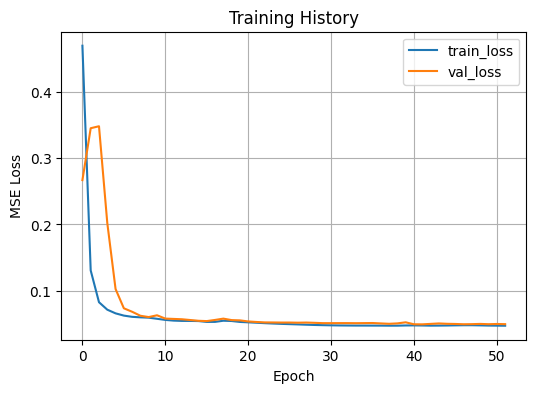

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.grid(True)
plt.show()

9. Reconstruction et visualisation des résultats

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 710ms/step


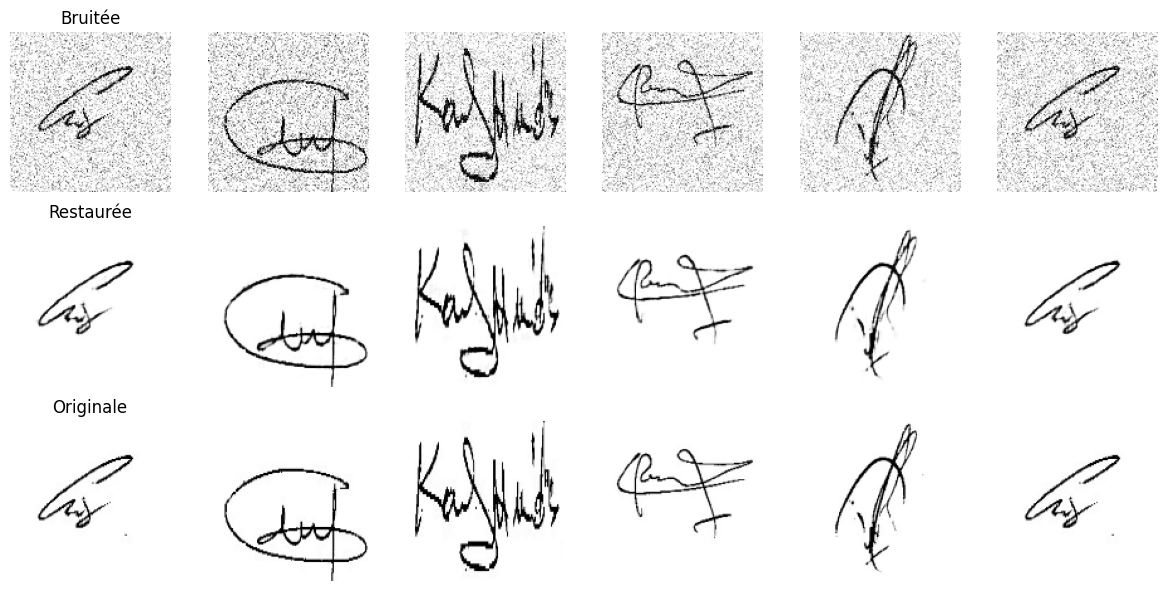

In [ ]:
decoded_test = autoencoder.predict(X_test_noisy)

n = min(6, X_test_noisy.shape[0])
plt.figure(figsize=(12, 6))

for i in range(n):
    # Bruitée
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    if i == 0: ax.set_title("Bruitée")

    # Restaurée
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(decoded_test[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    if i == 0: ax.set_title("Restaurée")

    # Originale
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(X_test_clean[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    if i == 0: ax.set_title("Originale")

plt.tight_layout()
plt.show()



In [ ]:
print(X_test_noisy.min(), X_test_noisy.max())
print(decoded_test.min(), decoded_test.max())


0.0 1.0
5.5187998e-06 1.0
